In [170]:
import numpy as np
from itertools import combinations
from tqdm.notebook import tqdm
from utils.visualization_animation import louvain_animation
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import metrics
from networkx.algorithms import community as nx_comm

# Implementation

## Modularity

In [135]:

def modularity_matrix(adj_matrix: np.ndarray) -> np.ndarray:
    k_i = np.expand_dims(adj_matrix.sum(axis=1), axis=1)
    k_j = k_i.T
    norm = 1 / k_i.sum()
    K = norm * np.matmul(k_i, k_j)

    return norm * (adj_matrix - K)


In [136]:
def modularity(adj_matrix: np.ndarray, communities: list) -> float:

    k_i = np.expand_dims(adj_matrix.sum(axis=1), axis=1)
    k_j = k_i.T

    weights_sum = k_i.sum()
    
    # if the nodes aren't linked we return the worst modularity
    if weights_sum == 0:
        return -1
    
    norm = 1 / weights_sum
    K = norm * np.matmul(k_i, k_j) # (ki * kj) / 2m
    mod_matrix = norm * (adj_matrix - K)  #  ( 1/2m ) *  Aij - (ki * kj) / 2m


    C = np.zeros_like(mod_matrix)

    for community in communities:
        for i, j in combinations(community, 2):
            C[i, j] = 1.0
            C[j, i] = 1.0

    return np.tril(np.multiply(mod_matrix, C), 0).sum()

In [137]:

def generate_adj_matrix(adj_matrix , V):
    # keep only the nodes in V
    # return adj_matrix[V][:,V]

    new_adj_matrix = adj_matrix.copy()

    for i in range(new_adj_matrix.shape[0]):
        if i not in V:
            new_adj_matrix[i, :] = 0
            new_adj_matrix[:, i] = 0
    
    return new_adj_matrix

In [138]:
def communities_to_frame( n , communities , modularity):

    nodes = list(range(n))

    for i, community in enumerate(communities):
        for node in community:
            nodes[node]  = i+1

    return {'C':nodes , 'Q':modularity}


In [139]:
frames = []

## Solution Initiale

In [140]:
def GCP(adj_matrix: np.ndarray) -> list:
    
    V = list(range(adj_matrix.shape[0]))
    
    v = np.random.choice(V)
    V.remove(v)
    
    K0 = [v]
    communities = [K0]
    nodes = [v]

    Mdb = -1

    while V:
        v = np.random.choice(V)
        Mdb = -1
        best_community = None
        best_community_index = -1

        

        new_adj_matrix = generate_adj_matrix(
            adj_matrix, nodes + [v])

        for i,Ki in enumerate(communities):
            Ki_new =  Ki + [v] 
            
            new_communities = communities.copy()
      
            new_communities[i] = Ki_new

            Md = modularity( new_adj_matrix, new_communities )

            if Md > Mdb:
                Mdb = Md
                best_community = Ki_new
                best_community_index = i

        #TODO : verify which formula to use
        if len(nodes)>1:
            # new_adj_matrix = generate_adj_matrix(adj_matrix, nodes)
            # Mdphi = modularity(new_adj_matrix, communities)

            new_adj_matrix = generate_adj_matrix(adj_matrix, nodes + [v])
            Mdphi = modularity(new_adj_matrix, communities + [[v]])
    

        else: 
            Mdphi = -1 

        if Mdb > Mdphi :
            communities[best_community_index] = best_community
            # print("Modularity : " , Mdb)
        else:

            Mdb = Mdphi
            # print("Modularity : " , Mdphi)
            Ki = [v]           
            communities.append(Ki) 


        nodes.append(v) 

        

        V.remove(v)
        
    return communities  , Mdb

## Iterative Greedy

### Destruction

In [141]:
def destruct(adj_matrix, communities , beta):

    nodes = list(range(adj_matrix.shape[0]))

    removed_nodes = np.random.choice(
        nodes, int(beta * len(nodes)), replace=False)

    filtered_communities = [] 
    for community in communities:

        new_community = [node for node in community if node not in removed_nodes]

        if new_community:
            filtered_communities.append(new_community)
    
    return removed_nodes , filtered_communities

## Reconstruction

In [142]:

def reconstruct(adj_matrix, communities, removed_nodes):

    # print("removed_nodes : " , removed_nodes)

    nodes = [node for node in list(range(adj_matrix.shape[0])) if node not in removed_nodes]


    Mdb = -1

    for node in removed_nodes:

        # print("Choosing Community for node : " , node)

        Mdb = -1
        best_community = None
        best_community_index = -1

        nodes.append(node)

        new_adj_matrix = generate_adj_matrix(adj_matrix, nodes )

        for i, Ki in enumerate(communities):
            Ki_new = Ki + [node]

            new_communities = communities.copy()
            new_communities[i] = Ki_new
            
            Md = modularity(new_adj_matrix, new_communities)

            if Md > Mdb:
                Mdb = Md
                best_community = Ki_new
                best_community_index = i


        Mdphi = modularity(new_adj_matrix, communities)


        # communities[best_community_index] = best_community
         
    
        if Mdb >= Mdphi:
            # print("Modularity : " , Mdb)
            communities[best_community_index] = best_community
            # print("Added to Community : " , best_community_index , " : " , best_community)
        else:
            # print("Modularity : " , Mdphi)
            Ki = [node]
            communities.append(Ki)
            Mdb = Mdphi
            # print("Added to new Community : " , Ki)
    
    return communities  , Mdb



    
    

In [143]:
modularity_trace = []
frames = []

## Original

In [144]:
def IG(adj_matrix , nb_iterations = 100 , beta=.4):
    frames.clear()
    # frames.append({'C':[i+1 for i in range(adj_matrix.shape[0]) ] , 'Q':0 })


    modularity_trace.clear()
    print(beta)
    print("GCP :")
    communities , mod = GCP(adj_matrix)

    modularity_trace.append(mod)
    frames.append(communities_to_frame(adj_matrix.shape[0] , communities , mod))


    print("communities : " , communities)
    # modularity_trace

    print("IG :")
    for i in tqdm(range(nb_iterations) , desc= "IG" , total=nb_iterations):

        removed_nodes, filtered_communities = destruct( adj_matrix, communities, beta)
        
        new_communities , mod = reconstruct(adj_matrix, filtered_communities, removed_nodes)

        if modularity(adj_matrix , new_communities) > modularity( adj_matrix , communities):
            communities = new_communities
            modularity_trace.append(mod)
            frames.append(communities_to_frame(adj_matrix.shape[0] , communities , mod))
        

        
    print("communities : " , len(communities))
    return communities

In [145]:

def communities_to_labels(G ,communities ):
    dic = {}
    for i, node in enumerate(G.nodes()):
        dic[i] = node

    res = []

    for index,community in enumerate(communities):

        for node in community:

            res.append(( dic[node] , index+1))

    return sorted(res)

In [146]:
def read_community_labels_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        res = []
        for line in lines:
            node, label = line.split()
            res.append((int(node)-1, int(label)))
        return res
    


In [147]:

def calc_nmi(true_labels, pred_labels):
    true_labels = [label for node, label in true_labels]
    pred_labels = [label for node, label in pred_labels]

    print(true_labels)
    print(pred_labels)
    return metrics.normalized_mutual_info_score(true_labels, pred_labels , average_method='min')




In [148]:
def generation_transformation_dict(G, nodes):
    dic = {}
    for i, node in enumerate(nodes):
        dic[i] = node

    return dic

In [149]:
def read_community_labels_file_reel(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        res = []
        for node ,label in enumerate(lines):
            res.append((int(node), int(label)+1))
        return res

# Tests

## Dolphins dataset

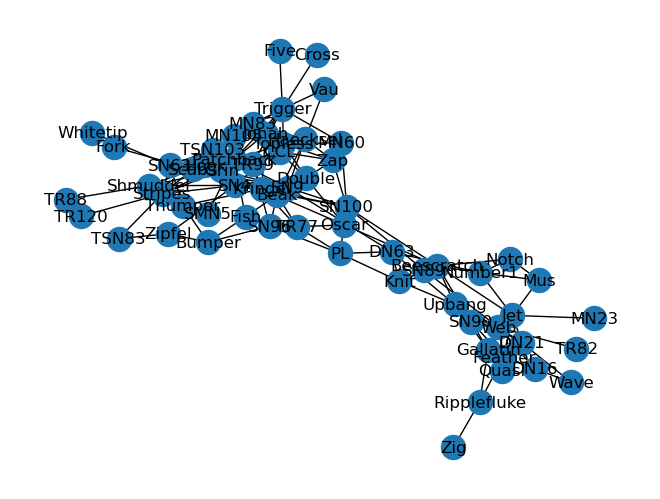

In [151]:

file_path = 'data/reel/dolphins/dolphins.gml'

# Read GML file into a NetworkX graph
G = nx.read_gml(file_path)

nx.draw(G, with_labels=True)
plt.show()

In [152]:
adj_matrix = nx.to_numpy_array(G)
adj_matrix.shape

(62, 62)

In [155]:
communities = IG(adj_matrix , 400, beta=.67)

0.67
GCP :
communities :  [[59, 8, 45, 15, 3, 28], [11, 51, 24, 4, 18, 29], [19, 1, 7, 41, 54, 26, 27, 25], [16, 20, 38, 14, 34, 49, 37, 44, 33, 52, 50, 46, 61, 43, 12, 53, 40, 58], [21], [9, 6, 17, 57, 22, 13, 32], [23], [35], [55], [56, 5], [42, 0, 10, 47, 30, 2], [31], [48], [60], [39, 36]]
IG :


IG:   0%|          | 0/400 [00:00<?, ?it/s]

communities :  4


In [156]:
true_labels = read_community_labels_file_reel('data/reel/dolphins/groundTruth.txt')

calc_nmi(true_labels, communities_to_labels(G, communities))

[1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1]
[4, 2, 4, 1, 1, 2, 2, 2, 1, 2, 4, 1, 3, 2, 3, 1, 3, 2, 1, 2, 3, 1, 2, 1, 1, 2, 2, 2, 4, 4, 1, 2, 2, 1, 3, 3, 3, 2, 3, 2, 4, 3, 3, 3, 3, 4, 2, 3, 3, 3, 4, 3, 1, 1, 2, 1, 2, 2, 3, 1, 2, 4]


0.6211412319513354

MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\2cs_project\Week2_Feb_22\Iterative-Greedy\utils\visualization_animation.py:295: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)


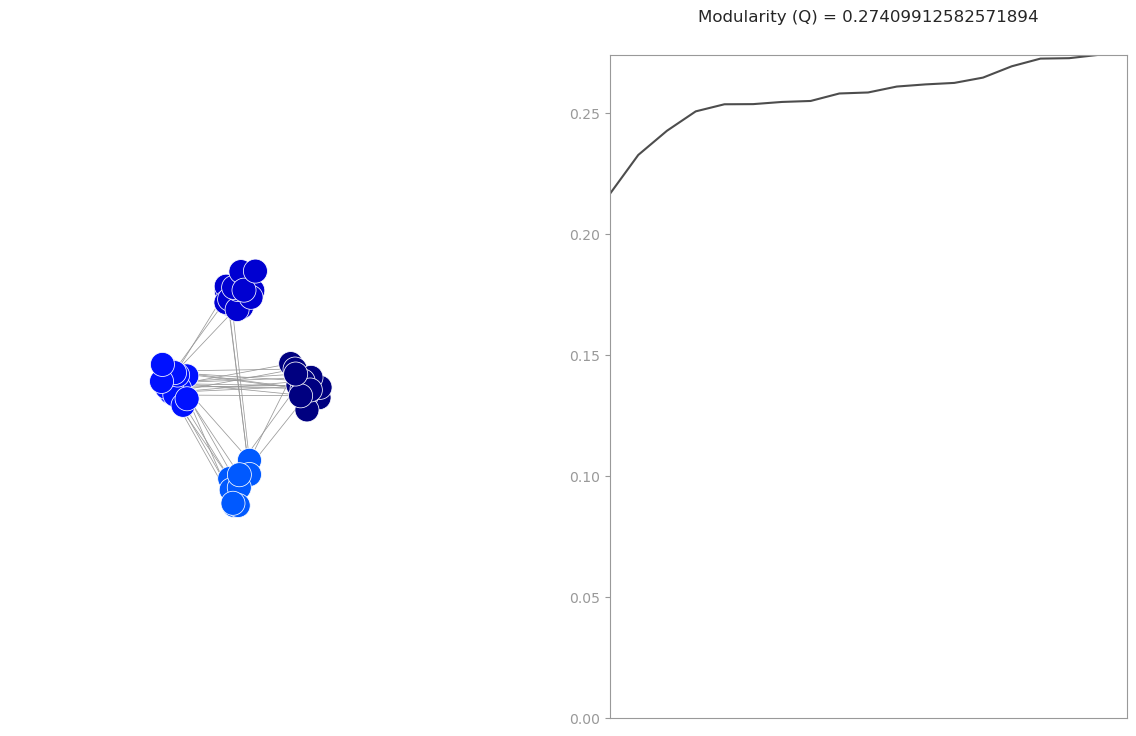

In [158]:
louvain_animation(adj_matrix, frames, dark=False , duration=20, filename="dophins.gif" ,dpi = 200 )

## Synthetic Datasets

# 0.15

In [159]:
G = nx.read_edgelist('./data/synth/LFR/0.15/network.dat', nodetype=int)

adj_matrix = nx.to_numpy_array(G)

In [160]:
communities = IG(adj_matrix, 50, beta=.7)

0.7
GCP :
communities :  [[40, 71, 125, 41, 119, 62, 99, 113, 69, 42, 43, 36, 45, 118, 121, 33, 126, 120, 47, 39, 68], [15, 7, 96, 4, 94, 93, 117, 38, 95, 97, 67, 11, 12, 13, 16, 9, 1, 8, 101, 89, 81, 90, 98, 14, 0, 88, 6, 92, 3], [111, 80, 55, 123, 102, 76, 109, 21, 103], [74, 37, 84, 116, 79, 20, 75, 78, 122, 114, 66, 115, 127, 86, 124, 31, 104, 85], [23, 105, 53, 106, 22, 54, 57, 26, 32, 110, 52, 17, 10, 19, 51, 59, 28, 25, 56, 58, 27, 18, 30, 60, 108, 107, 50, 29, 24, 2], [46, 34, 48, 65, 49, 70, 63, 35, 100, 64, 61], [87, 44, 91, 5], [112, 82, 77, 72, 83, 73]]
IG :


IG:   0%|          | 0/50 [00:00<?, ?it/s]

communities :  4


In [161]:

true_labels = read_community_labels_file('./data/synth/LFR/0.15/community.dat')

calc_nmi(true_labels, communities_to_labels(G, communities))


[3, 4, 2, 4, 2, 1, 3, 3, 3, 2, 1, 4, 4, 4, 4, 1, 3, 3, 2, 1, 3, 3, 4, 4, 2, 2, 3, 4, 2, 2, 4, 1, 3, 1, 3, 2, 4, 4, 2, 3, 2, 2, 4, 2, 1, 3, 3, 4, 1, 3, 3, 3, 3, 4, 1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 3, 1, 1, 4, 1, 2, 4, 3, 4, 3, 1, 3, 1, 2, 1, 2, 4, 4, 4, 3, 2, 2, 4, 3, 2, 2, 2, 2, 4, 2, 4, 4, 3, 1, 3, 2, 1, 1, 1, 2, 4, 4, 1, 2, 2, 3, 3, 1, 1, 2, 3, 2, 2, 3, 1, 4, 4, 2, 4, 2, 1, 4, 1, 3]
[2, 4, 1, 4, 1, 3, 2, 2, 2, 1, 3, 4, 4, 4, 4, 3, 2, 2, 1, 3, 2, 2, 4, 4, 1, 1, 2, 4, 1, 1, 4, 3, 2, 3, 2, 1, 4, 4, 1, 2, 1, 1, 4, 1, 3, 2, 2, 4, 3, 2, 2, 2, 2, 4, 3, 3, 3, 3, 3, 3, 4, 3, 2, 3, 2, 3, 3, 4, 3, 1, 4, 2, 4, 2, 3, 2, 3, 1, 3, 1, 4, 4, 4, 2, 1, 1, 4, 2, 1, 1, 1, 1, 4, 1, 4, 4, 2, 3, 2, 1, 3, 3, 3, 1, 4, 4, 3, 1, 1, 2, 2, 3, 3, 1, 2, 1, 1, 2, 3, 4, 4, 1, 4, 1, 3, 4, 3, 2]


1.0

Text(0, 0.5, 'Modularity')

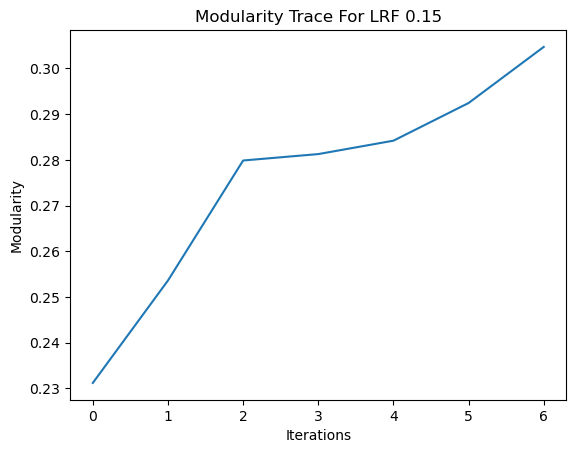

In [162]:
plt.plot(modularity_trace)
plt.title("Modularity Trace For LRF 0.15")
plt.xlabel("Iterations")
plt.ylabel("Modularity")

c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\2cs_project\Week2_Feb_22\Iterative-Greedy\utils\visualization_animation.py:295: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)
MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\2cs_project\Week2_Feb_22\Iterative-Greedy\utils\visualization_animation.py:295: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)


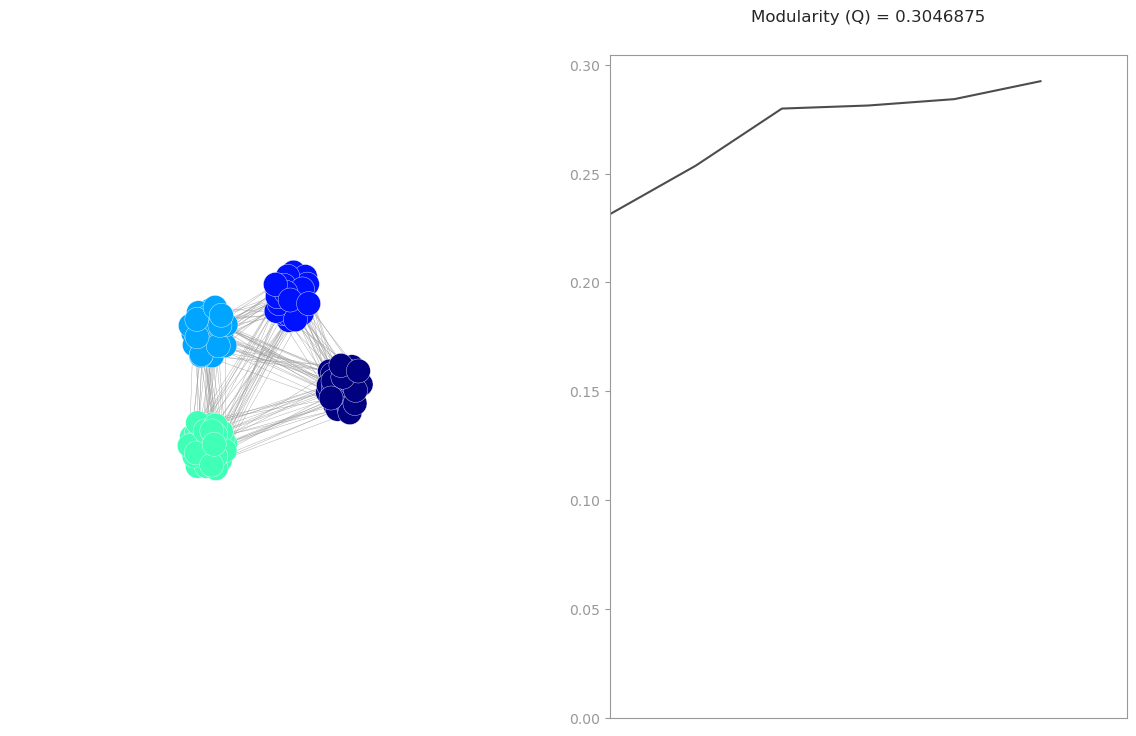

In [163]:
louvain_animation(adj_matrix, frames, dark=False , duration=60, filename="LRF015.gif" , dpi = 200 )

### 0.4

In [164]:
G = nx.read_edgelist('./data/synth/LFR/0.40/network.dat', nodetype=int)

adj_matrix = nx.to_numpy_array(G)

In [165]:
communities = IG(adj_matrix, 300, beta=.6)

0.6
GCP :
communities :  [[40, 111, 87, 7, 125, 4, 41, 72, 70, 32, 114, 43, 10, 64, 27, 18, 73, 30, 60, 50, 29, 3, 2], [15, 54, 119, 69, 26, 78, 36, 101, 51, 118, 108, 88, 31], [74, 44, 95, 67, 12, 42, 9, 45, 19, 89, 81, 21, 107], [23, 80, 71, 48, 77, 99, 79, 13, 76, 1, 100, 98, 115, 83, 109, 86, 103, 126, 14, 85], [46, 55, 105, 53, 106, 22, 91, 113, 97, 20, 110, 52, 17, 63, 16, 28, 33, 61, 24, 47, 39], [112, 37, 84, 96, 34, 65, 49, 94, 93, 62, 117, 38, 116, 11, 102, 59, 66, 90, 56, 58, 127, 124, 6, 120, 92, 68], [82, 5, 123, 57, 75, 122, 35, 8, 25, 121, 0, 104]]
IG :


IG:   0%|          | 0/300 [00:00<?, ?it/s]

communities :  4


In [166]:

true_labels = read_community_labels_file('./data/synth/LFR/0.40/community.dat')

calc_nmi(true_labels, communities_to_labels(G, communities))

[4, 1, 1, 1, 3, 4, 2, 4, 3, 1, 2, 4, 3, 1, 2, 3, 1, 1, 2, 4, 3, 3, 3, 4, 2, 1, 1, 2, 2, 4, 2, 1, 3, 3, 3, 3, 3, 3, 4, 2, 3, 1, 3, 2, 1, 1, 4, 4, 4, 1, 2, 4, 1, 1, 4, 2, 4, 3, 1, 1, 4, 4, 2, 1, 4, 3, 4, 3, 3, 1, 4, 2, 4, 1, 1, 2, 4, 2, 2, 4, 4, 4, 2, 2, 4, 4, 2, 2, 1, 4, 3, 2, 1, 3, 1, 1, 3, 2, 3, 1, 3, 3, 3, 2, 3, 3, 3, 1, 2, 4, 2, 1, 2, 1, 4, 2, 3, 1, 4, 2, 3, 3, 2, 4, 2, 2, 1, 4]
[1, 3, 3, 3, 4, 1, 2, 1, 4, 3, 2, 1, 4, 3, 2, 4, 3, 3, 2, 1, 4, 4, 4, 1, 2, 3, 3, 2, 2, 1, 2, 3, 4, 4, 4, 4, 4, 4, 1, 2, 4, 3, 4, 2, 3, 3, 1, 1, 1, 3, 2, 1, 3, 3, 1, 2, 1, 4, 3, 3, 1, 1, 2, 3, 1, 4, 1, 4, 4, 3, 1, 2, 1, 3, 3, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 3, 1, 4, 2, 3, 4, 3, 3, 4, 2, 4, 3, 4, 4, 4, 2, 4, 4, 4, 3, 2, 1, 2, 3, 2, 3, 1, 2, 4, 3, 1, 2, 4, 4, 2, 1, 2, 2, 3, 1]


1.0

Text(0, 0.5, 'Modularity')

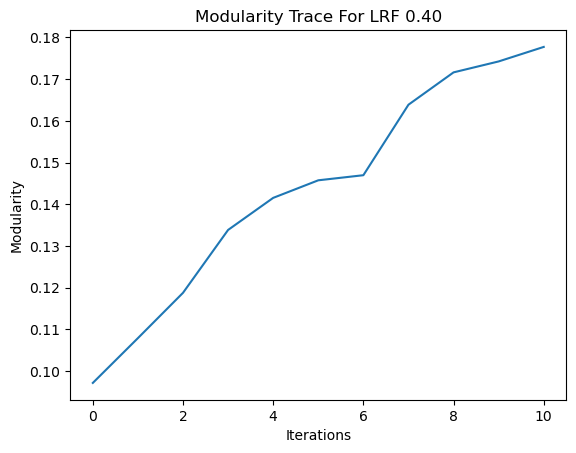

In [169]:
plt.plot(modularity_trace)
plt.title("Modularity Trace For LRF 0.40")
plt.xlabel("Iterations")
plt.ylabel("Modularity")

c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\2cs_project\Week2_Feb_22\Iterative-Greedy\utils\visualization_animation.py:295: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)
MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\2cs_project\Week2_Feb_22\Iterative-Greedy\utils\visualization_animation.py:295: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)


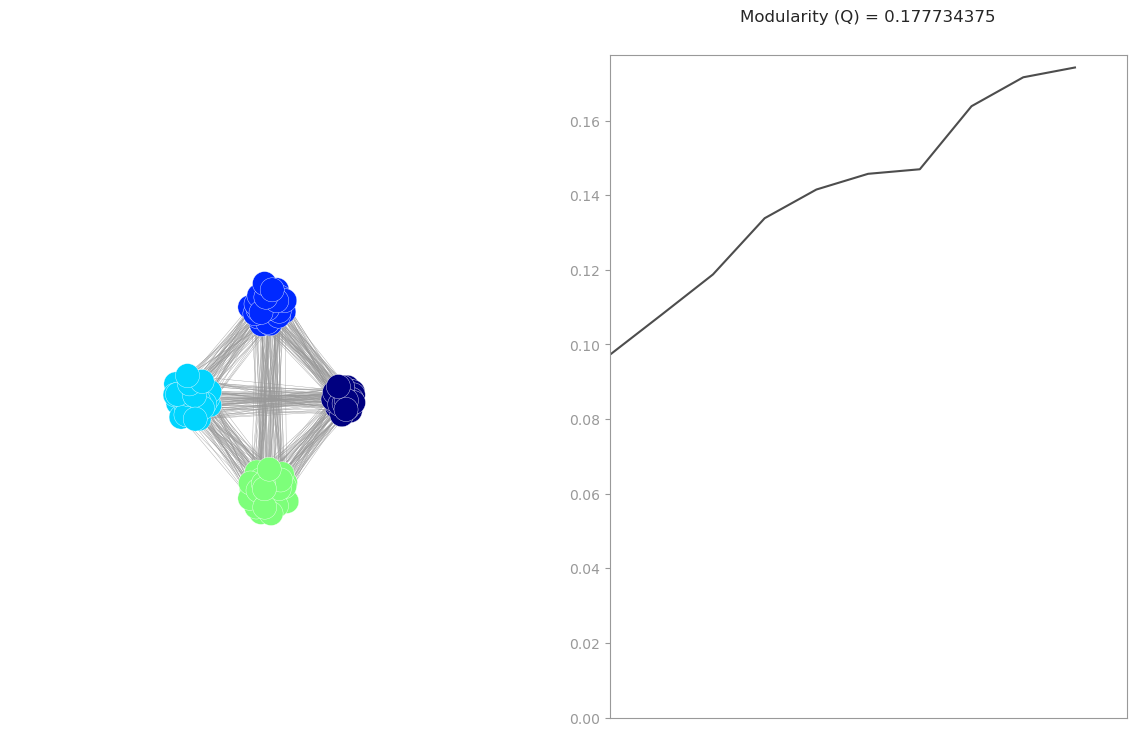

In [168]:
louvain_animation(adj_matrix, frames, dark=False , duration=50, filename="LRF40.gif" ,dpi = 200 )

In [171]:
G = nx.read_edgelist('./data/synth/LFR/0.50/network.dat', nodetype=int)

adj_matrix = nx.to_numpy_array(G)

In [176]:
communities = IG(adj_matrix, 40, beta=.5)

0.5
GCP :
communities :  [[41, 123, 53, 127, 103, 101, 28, 113, 21, 45, 119, 93, 114, 33, 124, 86, 78, 32, 76, 54, 42, 36, 117, 89], [18, 98, 96, 26, 49, 24, 105, 17, 20, 7, 64, 99, 91, 109, 83, 3, 70, 27, 110, 31, 125, 38, 122, 107, 111, 37, 44, 80, 84, 95, 115, 74], [71, 66, 30, 47, 121, 126, 77, 29, 43, 94, 88, 79, 8, 72, 112, 120, 14, 85, 106, 39, 67, 75, 4, 58, 62, 35, 22, 81, 15, 116, 16, 5], [87, 61, 23, 118, 40, 97, 82, 11, 9, 34, 92, 12, 48, 13, 59, 2, 57, 1, 50, 100, 52, 25, 10, 55, 46, 56, 0], [73, 6, 104, 108, 19, 69, 51, 90, 63, 60, 65, 68, 102]]
IG :


IG:   0%|          | 0/40 [00:00<?, ?it/s]

communities :  5


In [177]:

true_labels = read_community_labels_file('./data/synth/LFR/0.50/community.dat')

calc_nmi(true_labels, communities_to_labels(G, communities))

[3, 2, 3, 2, 1, 2, 2, 3, 3, 3, 4, 1, 4, 1, 1, 4, 1, 2, 2, 2, 1, 4, 2, 1, 3, 2, 3, 1, 3, 1, 2, 1, 2, 2, 4, 4, 1, 2, 2, 2, 1, 4, 4, 1, 4, 3, 3, 1, 1, 1, 4, 1, 2, 3, 1, 3, 4, 3, 1, 1, 3, 4, 3, 2, 2, 4, 4, 3, 4, 1, 4, 2, 4, 2, 4, 4, 3, 3, 3, 2, 2, 1, 3, 3, 1, 4, 3, 3, 2, 2, 4, 3, 3, 4, 4, 2, 3, 1, 1, 1, 3, 1, 3, 4, 4, 2, 3, 1, 4, 4, 3, 2, 4, 2, 1, 1, 2, 4, 3, 2, 4, 4, 1, 1, 4, 3, 2, 2]
[4, 5, 1, 1, 1, 3, 1, 4, 4, 4, 3, 2, 3, 2, 5, 3, 4, 1, 4, 5, 1, 3, 1, 2, 4, 1, 4, 4, 4, 2, 1, 2, 1, 2, 3, 3, 2, 1, 4, 1, 2, 3, 3, 2, 3, 4, 4, 2, 2, 2, 3, 2, 1, 1, 3, 1, 3, 1, 3, 5, 4, 3, 4, 1, 1, 3, 3, 1, 3, 2, 3, 5, 3, 4, 3, 3, 4, 4, 4, 4, 3, 1, 1, 4, 2, 3, 1, 4, 5, 1, 3, 4, 2, 3, 3, 2, 4, 2, 3, 4, 1, 2, 4, 3, 3, 5, 4, 2, 3, 3, 1, 5, 3, 4, 2, 2, 5, 3, 4, 3, 3, 3, 3, 2, 3, 1, 5, 4]


0.5037758576480069

c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\2cs_project\Week2_Feb_22\Iterative-Greedy\utils\visualization_animation.py:295: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)
MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\ASUS ROG\OneDrive\Desktop\ESI\Current\S2\Projet\2cs_project\Week2_Feb_22\Iterative-Greedy\utils\visualization_animation.py:295: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)


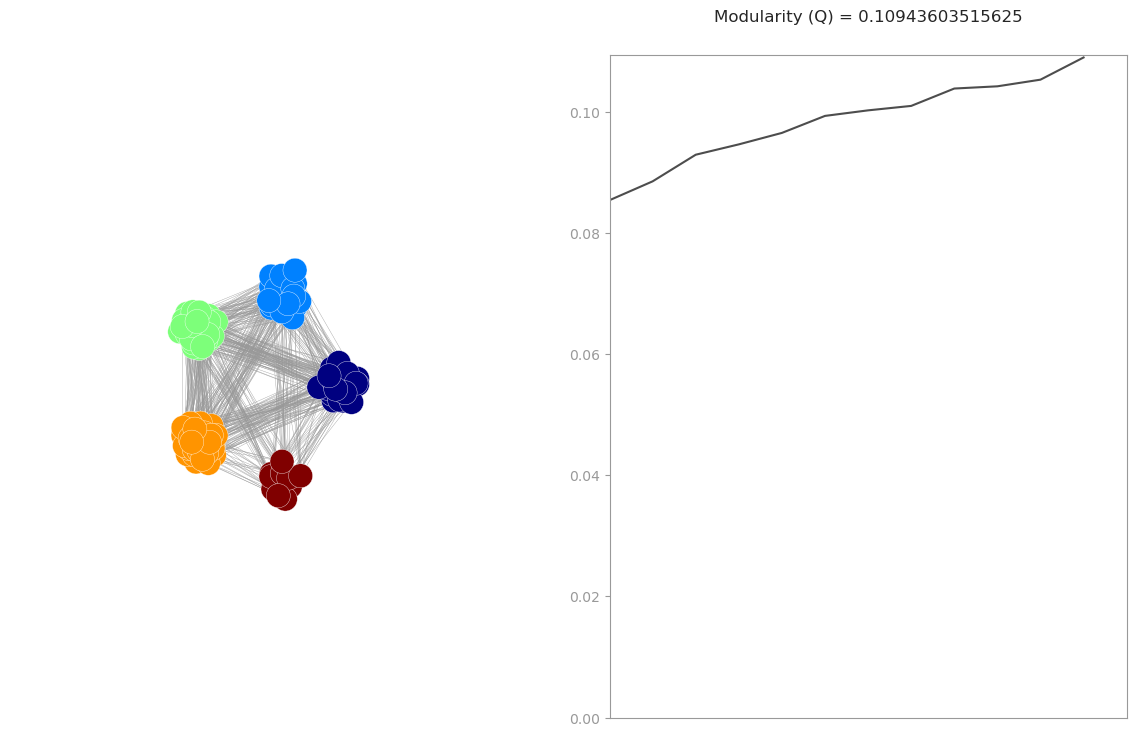

In [178]:
louvain_animation(adj_matrix, frames, dark=False , duration=50, filename="LRF50.gif" , dpi = 200 )